In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
df = pd.read_csv("boston.csv")

0.2166209012915364


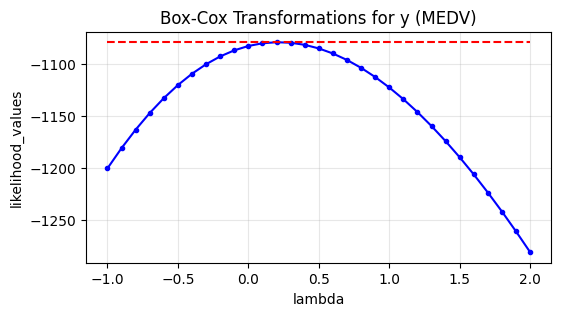

In [88]:
# Box-Cox Transformations for y (Median value of owner-occupied homes in $1000's)
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['MEDV'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['MEDV']) for i in lamb]
fig = plt.figure(figsize=(6,3))
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (MEDV)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)
print(fitted_lambda)

In [89]:
df['lnMEDV'] = np.log(df['MEDV'])

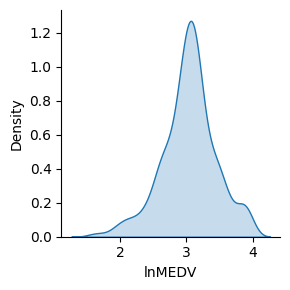

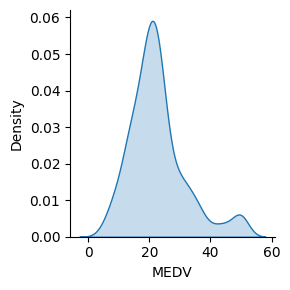

In [90]:
sns.displot(df, x='lnMEDV', kind="kde", fill=True, height=3)
sns.displot(df, x='MEDV', kind="kde", fill=True, height=3)

In [91]:
# Split training dataset and validation dataset
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df.drop(['MEDV'], axis=1), test_size=0.5, random_state=1)

In [295]:
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

In [93]:
# Data explore
# sns.pairplot(df)

In [94]:
from statsmodels.formula.api import ols ,wls
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

In [95]:
# Run simple regression for every X
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in training_set.columns.drop('lnMEDV'):
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid

In [453]:
pd.set_option('display.float_format', '{:.3f}'.format)
simple_reg_result = pd.DataFrame(reg_result, index=training_set.columns.drop('lnMEDV'), columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)
simple_reg_result

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


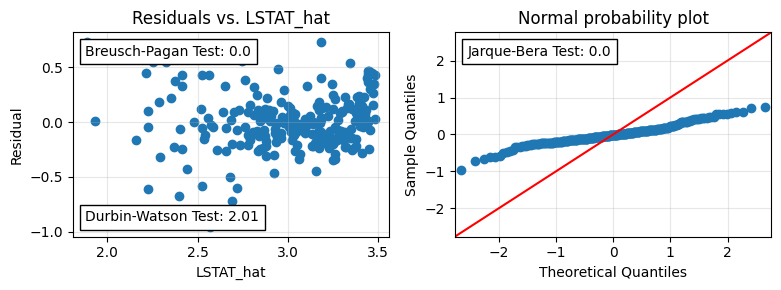

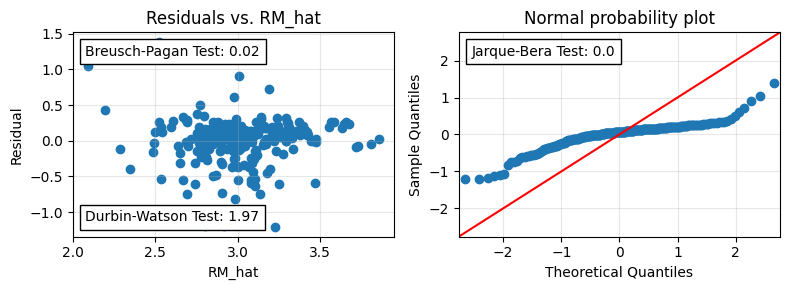

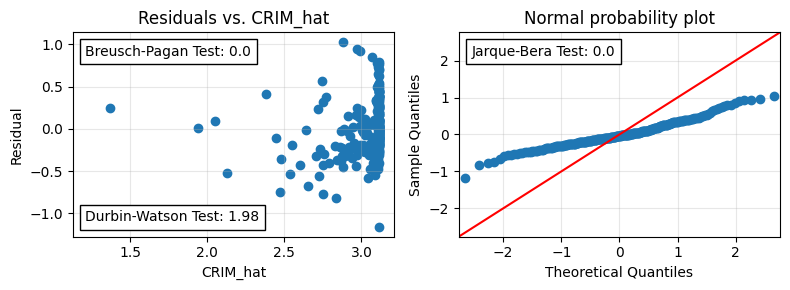

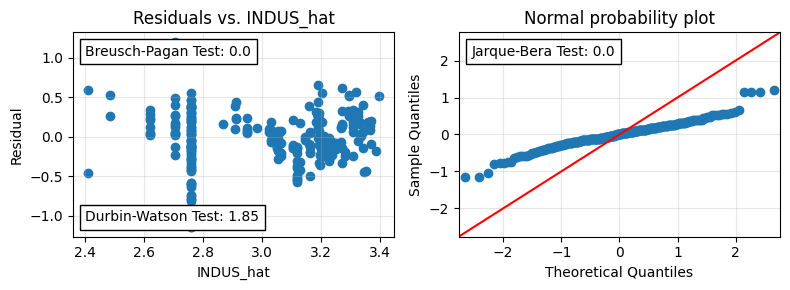

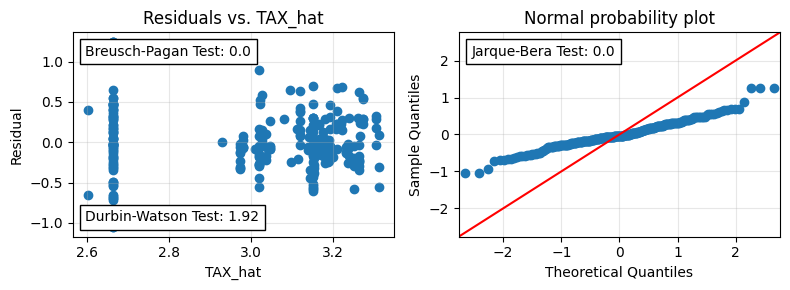

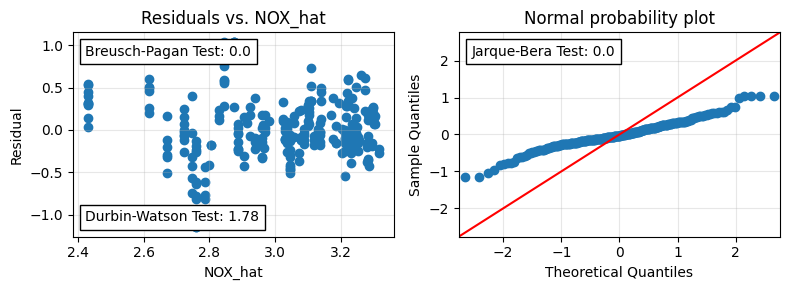

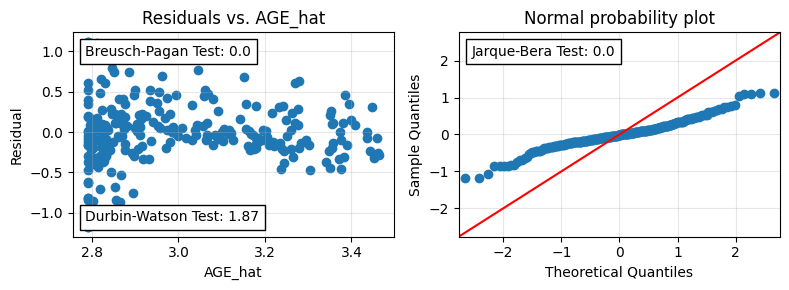

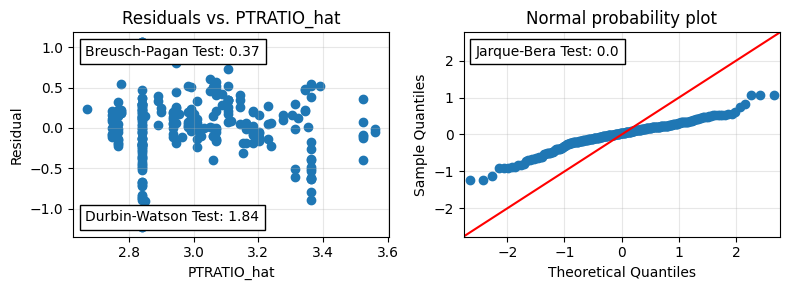

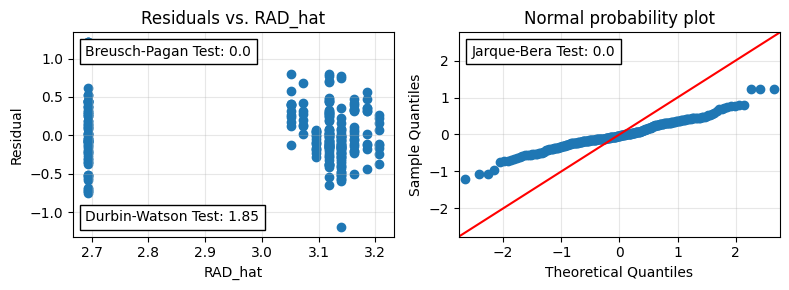

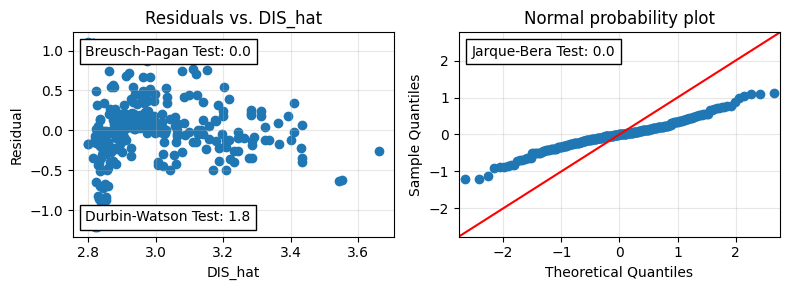

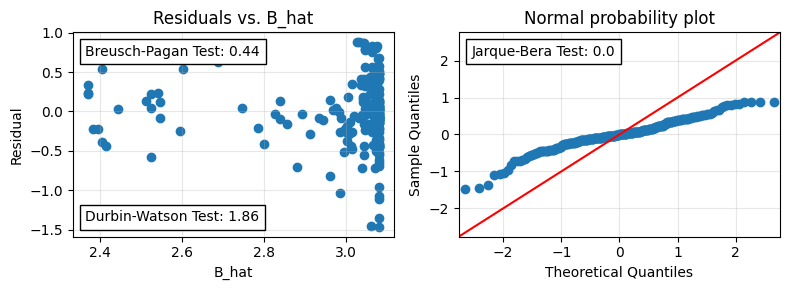

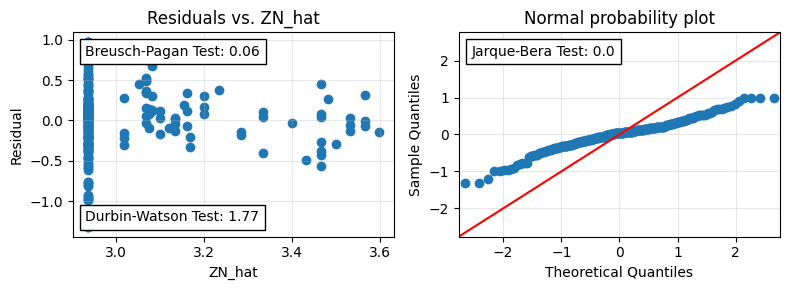

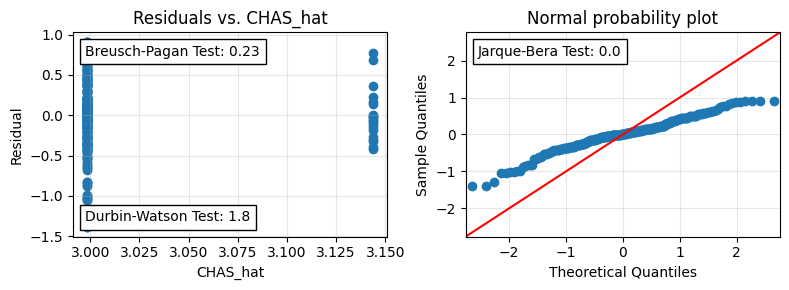

In [101]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('Residuals vs. '+i+'_hat')
        axs[0].set_ylabel('Residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)
        anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(simple_reg_result.loc[i,'Durbin-Watson test'],2)), loc=3)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

In [102]:
candidate = simple_reg_result[simple_reg_result['abs(tValue)']>2]
candidate

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.05,21.84,2.01,0.00,0.00
RM,0.39,13.20,1.97,0.00,0.02
CRIM,-0.03,11.45,1.98,0.00,0.00
INDUS,-0.04,11.32,1.85,0.00,0.00
TAX,-0.00,10.45,1.92,0.00,0.00
NOX,-1.85,9.97,1.78,0.00,0.00
AGE,-0.01,8.91,1.87,0.00,0.00
PTRATIO,-0.09,8.91,1.84,0.00,0.37
RAD,-0.02,8.41,1.85,0.00,0.00
DIS,0.08,7.09,1.80,0.00,0.00


In [134]:
partial_f_test_treshold = 0.05

In [248]:
X_candidate = candidate.index[1:]
X_candidate_collection = [candidate.index[0]]

while len(X_candidate) > 0:
    add_list = {}
    for i in X_candidate:
        
        syntax_var = str(X_candidate_collection+[i]).replace("[","").replace("]","").replace("'","").replace(","," +")
        reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
        
        hypotheses = '('+i+' = 0)'
        partial_f_test = reg_model.f_test(hypotheses).pvalue
        add_list[i] = partial_f_test
        print("model contains: "+syntax_var)
    add_list = pd.Series(add_list).sort_values()
    print(add_list.iloc[[0]])
    if add_list.iloc[0] < partial_f_test_treshold:
        X_candidate_collection.append(add_list.index[0])
    else:
        break
    # check whether affect previous variables
    syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
    reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
    variables_pValue = reg_model.pvalues[1:]
    delete_var = variables_pValue.where(variables_pValue > 0.05).dropna().index.to_list()
    [X_candidate_collection.remove(delete) for delete in delete_var]

    X_candidate = X_candidate.drop(add_list.index[0])
    

model contains: LSTAT + RM
model contains: LSTAT + CRIM
model contains: LSTAT + INDUS
model contains: LSTAT + TAX
model contains: LSTAT + NOX
model contains: LSTAT + AGE
model contains: LSTAT + PTRATIO
model contains: LSTAT + RAD
model contains: LSTAT + DIS
model contains: LSTAT + B
model contains: LSTAT + ZN
CRIM   0.00
dtype: float64
model contains: LSTAT + CRIM + RM
model contains: LSTAT + CRIM + INDUS
model contains: LSTAT + CRIM + TAX
model contains: LSTAT + CRIM + NOX
model contains: LSTAT + CRIM + AGE
model contains: LSTAT + CRIM + PTRATIO
model contains: LSTAT + CRIM + RAD
model contains: LSTAT + CRIM + DIS
model contains: LSTAT + CRIM + B
model contains: LSTAT + CRIM + ZN
PTRATIO   0.00
dtype: float64
model contains: LSTAT + CRIM + PTRATIO + RM
model contains: LSTAT + CRIM + PTRATIO + INDUS
model contains: LSTAT + CRIM + PTRATIO + TAX
model contains: LSTAT + CRIM + PTRATIO + NOX
model contains: LSTAT + CRIM + PTRATIO + AGE
model contains: LSTAT + CRIM + PTRATIO + RAD
model con

In [348]:
syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
reg_model_validation = ols('lnMEDV ~ '+ syntax_var, data=validation_set).fit()


In [251]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     183.8
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           6.28e-73
Time:                        18:53:00   Log-Likelihood:                 34.818
No. Observations:                 253   AIC:                            -59.64
Df Residuals:                     248   BIC:                            -41.97
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3337      0.234     14.255      0.0

In [349]:
print(reg_model_validation.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     175.5
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           4.40e-71
Time:                        19:57:50   Log-Likelihood:                 45.892
No. Observations:                 253   AIC:                            -81.78
Df Residuals:                     248   BIC:                            -64.12
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3220      0.219     15.161      0.0

<Axes: >

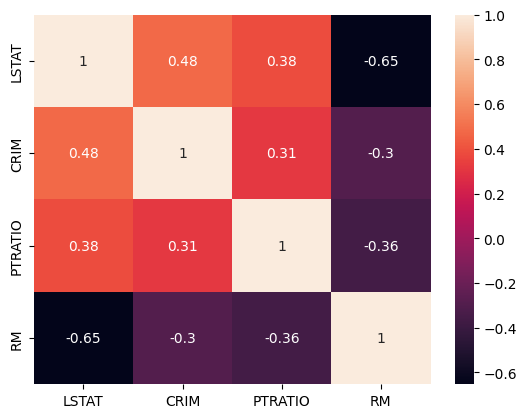

In [256]:
sns.heatmap(training_set[X_candidate_collection].corr(), annot=True)

In [253]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [255]:
VIF = pd.DataFrame()
VIF['feature']  = X_candidate_collection
VIF['VIF'] = [variance_inflation_factor(training_set[X_candidate_collection].values, i) for i in range(training_set[X_candidate_collection].shape[1])]
VIF

,feature,VIF
0,LSTAT,6.94
1,CRIM,1.56
2,PTRATIO,55.01
3,RM,38.27


In [257]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]

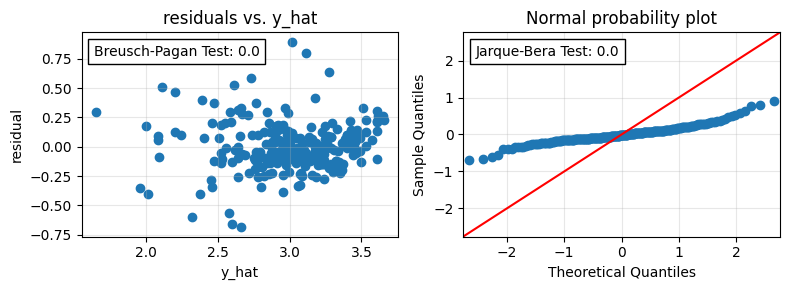

In [258]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)


sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

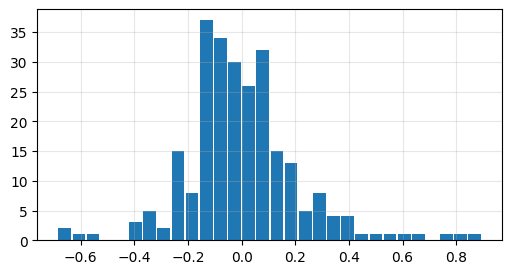

In [286]:
ax1 = reg_model.resid.hist(bins=30, figsize=(6,3), rwidth=0.9)
ax1.grid(alpha = 0.3)

In [351]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

residual_data_valid = pd.concat([abs(reg_model_validation.resid),reg_model_validation.fittedvalues], axis=1)
residual_data_valid.columns = ['abs_residual', 'y_hat']
residual_model_valid = ols('abs_residual ~ y_hat', data=residual_data_valid).fit()

In [354]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
wls_whole_model_valid = wls('lnMEDV ~ '+ syntax_var, data=validation_set, weights = 1/residual_model_valid.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.771
Model:                            WLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     209.2
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           3.20e-78
Time:                        20:00:25   Log-Likelihood:                 51.680
No. Observations:                 253   AIC:                            -93.36
Df Residuals:                     248   BIC:                            -75.69
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9597      0.217     13.625      0.0

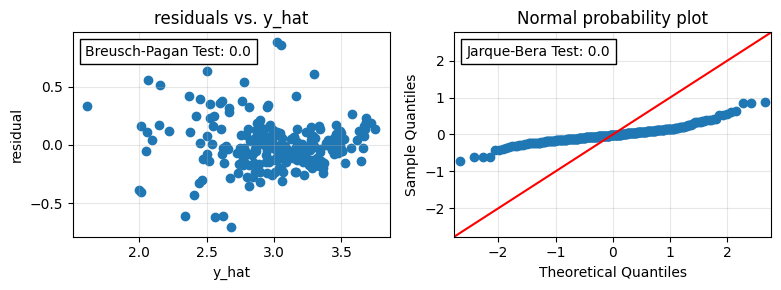

In [289]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(wls_whole_model.fittedvalues, wls_whole_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)


sm.qqplot(wls_whole_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

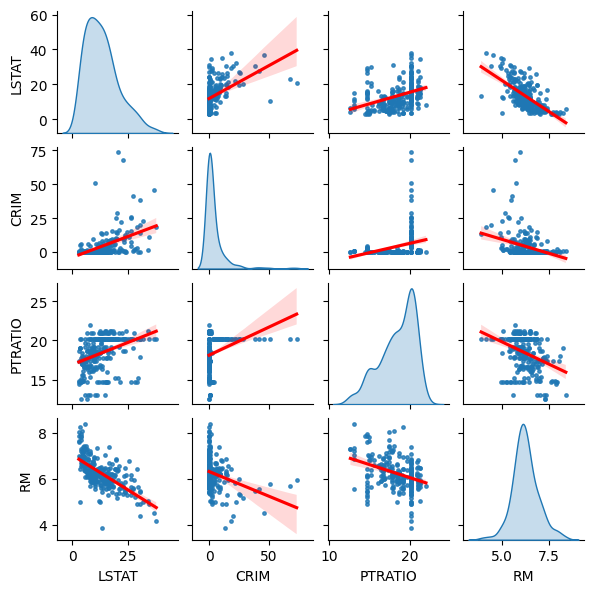

In [322]:
# Data explore
g = sns.pairplot(training_set[X_candidate_collection], kind="reg", corner=False, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':6}}, diag_kind='kde', height=1.5)

In [290]:
def press_criterion(reg_data, ind_variables, freq):
    press = 0
    for i in range(0, len(reg_data)-freq+1, freq):
        wls_model = wls('lnMEDV ~ '+ind_variables, data=reg_data.drop(range(i,i+freq)), weights = 1/residual_model.fittedvalues.drop(range(i,i+freq))).fit()
        press += ((wls_model.predict(reg_data[ind_variables.split(' + ')].iloc[i:i+freq]).values[0] - reg_data['lnMEDV'][i:i+freq])**2).sum()
    return press

def mallows_cp(reg_data, muliple_variable_list, wls_whole_model, wls_model):
    c = wls_model.ssr/wls_whole_model.mse_resid-(len(reg_data)-2*(len(muliple_variable_list)+1)+1)
    return c
    
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

In [422]:
combs(X_candidate_collection)[1:]

[['LSTAT'],
 ['CRIM'],
 ['CRIM', 'LSTAT'],
 ['PTRATIO'],
 ['PTRATIO', 'LSTAT'],
 ['PTRATIO', 'CRIM'],
 ['PTRATIO', 'CRIM', 'LSTAT'],
 ['RM'],
 ['RM', 'LSTAT'],
 ['RM', 'CRIM'],
 ['RM', 'CRIM', 'LSTAT'],
 ['RM', 'PTRATIO'],
 ['RM', 'PTRATIO', 'LSTAT'],
 ['RM', 'PTRATIO', 'CRIM'],
 ['RM', 'PTRATIO', 'CRIM', 'LSTAT']]

In [423]:
powerset_var = combs(X_candidate_collection)[1:]
criterions = []
k = 0
for i in powerset_var:
    ind_var = str(i).replace("'",'').replace("[",'').replace("]",'').replace(",",' +')
    reg_model = ols('lnMEDV ~ '+ind_var, data=training_set).fit()
    
    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
    
    wls_model = wls('lnMEDV ~ '+ind_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
    
    p = len(i)
    sse = wls_model.ssr
    rsq = wls_model.rsquared
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i, wls_whole_model, wls_model)
    aic = wls_model.aic
    bic = wls_model.bic
    press = press_criterion(training_set, ind_var, 1)
    criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [424]:
criterions_df = pd.DataFrame(criterions, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')

In [425]:
criterions_df.sort_values('Cp').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
RM + PTRATIO + CRIM + LSTAT,4,67.39,0.77,0.77,4.00,-93.36,-75.69,12.25
RM + CRIM + LSTAT,3,68.40,0.75,0.75,5.71,-75.89,-61.75,13.13
PTRATIO + CRIM + LSTAT,3,71.06,0.72,0.72,15.49,-53.36,-39.23,12.58
RM + PTRATIO + LSTAT,3,72.59,0.76,0.76,21.11,-68.92,-54.78,13.95
CRIM + LSTAT,2,73.24,0.69,0.69,21.52,-32.13,-21.53,13.67
RM + LSTAT,2,75.39,0.74,0.74,29.44,-49.53,-38.93,15.37
PTRATIO + LSTAT,2,75.76,0.70,0.70,30.81,-31.86,-21.26,14.19
LSTAT,1,79.85,0.67,0.66,43.84,-7.57,-0.50,15.86
RM + PTRATIO + CRIM,3,86.88,0.73,0.73,73.72,-7.15,6.99,18.25


In [303]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
RM + PTRATIO + CRIM + LSTAT,4,67.39,0.77,0.77,4.00,-93.36,-75.69,12.25
PTRATIO + CRIM + LSTAT,3,71.06,0.72,0.72,15.49,-53.36,-39.23,12.58
RM + CRIM + LSTAT,3,68.40,0.75,0.75,5.71,-75.89,-61.75,13.13
CRIM + LSTAT,2,73.24,0.69,0.69,21.52,-32.13,-21.53,13.67
RM + PTRATIO + LSTAT,3,72.59,0.76,0.76,21.11,-68.92,-54.78,13.95
PTRATIO + LSTAT,2,75.76,0.70,0.70,30.81,-31.86,-21.26,14.19
RM + LSTAT,2,75.39,0.74,0.74,29.44,-49.53,-38.93,15.37
LSTAT,1,79.85,0.67,0.66,43.84,-7.57,-0.50,15.86
RM + PTRATIO + CRIM,3,86.88,0.73,0.73,73.72,-7.15,6.99,18.25


In [507]:
Top3Model = criterions_df.sort_values('PRESS').index[:3].values
col = Top3Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top3Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]

    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).sum()/(wls_model.df_resid)

    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a


    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

In [508]:
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.731
Model:                            WLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     225.3
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           1.22e-70
Time:                        21:40:15   Log-Likelihood:                 39.621
No. Observations:                 253   AIC:                            -71.24
Df Residuals:                     249   BIC:                            -57.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2930      0.159     14.441      0.0

In [509]:
wls_model.df_resid

249.0

In [510]:
assessment_table

,RM + PTRATIO + CRIM + LSTAT (Training),RM + PTRATIO + CRIM + LSTAT (Validation),PTRATIO + CRIM + LSTAT (Training),PTRATIO + CRIM + LSTAT (Validation),RM + CRIM + LSTAT (Training),RM + CRIM + LSTAT (Validation)
p,4,4,3,3,3,3
LSTAT_b,-0.029,-0.029,-0.037,-0.037,-0.031,-0.031
CRIM_b,-0.009,-0.009,-0.009,-0.009,-0.010,-0.010
PTRATIO_b,-0.027,-0.027,-0.034,-0.034,NaN,NaN
RM_b,0.157,0.157,NaN,NaN,0.176,0.176
LSTAT_std(b),0.003,0.003,0.002,0.002,0.003,0.003
CRIM_std(b),0.002,0.002,0.002,0.002,0.002,0.002
PTRATIO_std(b),0.006,0.006,0.007,0.007,NaN,NaN
RM_std(b),0.023,0.023,NaN,NaN,0.024,0.024
SSE,11.507,10.407,12.028,11.615,12.413,11.684


In [515]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[0].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[0].split(' + ')].values, i) for i in range(training_set[Top3Model[0].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,38.266
1,PTRATIO,55.012
2,CRIM,1.556
3,LSTAT,6.938


In [518]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[1].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[1].split(' + ')].values, i) for i in range(training_set[Top3Model[1].split(' + ')].shape[1])]
VIF

,feature,VIF
0,PTRATIO,4.910
1,CRIM,1.520
2,LSTAT,5.869


In [519]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[2].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[2].split(' + ')].values, i) for i in range(training_set[Top3Model[2].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,3.416
1,CRIM,1.543
2,LSTAT,4.335
